# Donut 🍩, Document understanding transformer

### Task: Visual Question Answering

can be finetuned for both `Extractive and abstractive question answering`

![model image](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/donut_architecture.jpg)

[paper: OCR-free Document Understanding Transformer](https://huggingface.co/papers/2111.15664)

[clovaai/donut Github](https://github.com/clovaai/donut?tab=readme-ov-file)

[donut-base model on huggingface](https://huggingface.co/naver-clova-ix/donut-base/)


### TEXT FORMAT

**during training:**

- **INPUT:**
  - Image embedding
  - task_start_token + bos_token + json2token(ground_truth_json) + eos_token

**during inference:**

- **INPUT:**
  - Image embedding
  - initial prompt

- **OUTPUT:**
  - ground_truth_json

In [ ]:
!pip show transformers

In [ ]:
!git clone https://github.com/hftuner/clovaai-donut.git /content/hftuner

In [ ]:
import os
import json
from datasets import load_dataset, DatasetDict

dataset = load_dataset('hf-tuner/docvqa-10k-donut')

In [ ]:
ignore_id = -100
task_start_token = "<doc_vqa>"
new_special_tokens = []

new_special_tokens.extend([task_start_token])


In [ ]:
from hftuner.donut import DataProcessor

data_processor = DataProcessor()
json2token = data_processor.json2token

example_vqa_gt = [
    {"question" : "what is the model name?", "answer" : "donut"},
     {"question" : "what is the model name?", "answer" : "document understanding transformer"}
    ] #gt_parses

example_vqa_gt = {"question" : "what is the model name?", "answer" : "donut"} #gt_parse

json2token(example_vqa_gt)

## special tokens from dataset

In [ ]:
def clean_docs_for_donut(sample):
    gt = json.loads(sample["ground_truth"])
    parsed_text = gt['gt_parse'] if 'gt_parse' in gt else gt['gt_parses']
    text = json2token(parsed_text, update_special_tokens_for_json_key=True) # adds a new token for each key
    return {"text": text}

columns_to_remove = [ c for c in dataset['train'].column_names if c not in ['image', 'ground_truth', 'text']]

data_processor.clear_new_special_tokens()
proc_dataset = dataset.map(clean_docs_for_donut, remove_columns=columns_to_remove)
new_key_tokens = data_processor.get_new_special_tokens()

print(f"Sample:\n{proc_dataset['train'][4]['text']}")
# bos_token and eos_token will be added by data collator function

## load model and processor

In [ ]:
import torch
from transformers import DonutProcessor, VisionEncoderDecoderConfig
from hftuner.donut import DonutModel

ckpt = 'naver-clova-ix/donut-base'
processor = DonutProcessor.from_pretrained(ckpt)
model = DonutModel.from_pretrained(ckpt)

len(processor.tokenizer)

## Configure processor and model for finetuning

In [ ]:

new_special_tokens = list(set(new_special_tokens + new_key_tokens))

print(f"New special tokens:  {new_special_tokens}")

# add new special tokens to tokenizer
print(f"Adding {len(new_special_tokens)} special tokens")
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens})

# https://x.com/karpathy/status/1621578354024677377?lang=en
multiplier = 64
if len(processor.tokenizer) % multiplier != 0:
  extra_token_count = multiplier - (len(processor.tokenizer) % multiplier)
  print(f"Adding {extra_token_count} fake tokens")
  fake_tokens = [f"<reserved_{i+1}>" for i in range(extra_token_count)]
  processor.tokenizer.add_tokens(fake_tokens)

print(f"New tokenizer length: {len(processor.tokenizer)}")


In [ ]:
# to find max_token to output during training
def add_token_count(example):
  example['tokens_count'] = processor.tokenizer(
      example['text'],
      add_special_tokens=True,
      return_tensors="pt",
  ).input_ids[0].shape[0]
  return example

proc_dataset = proc_dataset.map(add_token_count)
max_length = max(proc_dataset['train']['tokens_count'])
print('maximum length of example:', max_length)



In [ ]:
processor.image_processor.size

In [ ]:
max_length = 64
processor_image_size = [1080, 1920] # (width, height)

## UPDATE: processor
processor.image_processor.size['width'] = processor_image_size[0]
processor.image_processor.size['height'] = processor_image_size[1]
processor.image_processor.do_align_long_axis = False # don't rotate image if height is greater than width

## UPDATE: model

# generation config
model.config.decoder.max_length = max_length
model.config.pad_token_id = processor.tokenizer.pad_token_id

# ⚠️ IMPORTANT: set decoder_start_token (used to create inputs to decoder from `labels`)
# https://github.com/huggingface/transformers/blob/071eb5334f5a9ac2c7a13515219be8a272388ec6/src/transformers/models/vision_encoder_decoder/modeling_vision_encoder_decoder.py#L34
task_token_id = processor.tokenizer.encode(task_start_token, add_special_tokens=False)[0]
model.config.decoder_start_token_id = task_token_id

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))

# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor_image_size[::-1] # (height, width)

print(f"New token embedding size: {new_emb}")

More about : [decoder_start_token_id](https://github.com/huggingface/transformers/blob/4df2529d79d75f44e70396df5888a32ffa02d61e/src/transformers/models/vision_encoder_decoder/modeling_vision_encoder_decoder.py#L331)

## Data Collator

In [ ]:
prompt_end_token = "<s_answer>"
prompt_end_token_id = processor.tokenizer.encode(prompt_end_token, add_special_tokens=False)[0]
print(f"prompt_end_token_id: {prompt_end_token_id}")

def prepare_data(examples):
    images = [e['image'].convert("RGB") for e in examples]
    texts = [e['text'] for e in examples]
    # create tensor from image
    pixel_values = processor(
        images,
        return_tensors="pt"
        ).pixel_values
    # tokenize text
    input_ids = processor.tokenizer(
        texts,
        add_special_tokens=True, # add <s> and </s>
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ).input_ids
    labels = input_ids.clone()

    decoder_input_ids = model.prepare_decoder_input_ids_from_labels(labels) #shifts to the right and add task_start_token_id at the start
    # ignore pad tokens when calculating `loss`
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id
    # ignore prompt tokens when calculating `loss`
    prompt_end_indices = torch.argmax((labels == prompt_end_token_id).int(), dim=1) # for each row in the batch
    for i in range(labels.shape[0]):
        labels[i, :prompt_end_indices[i]+1] = ignore_id
    return {"pixel_values": pixel_values, "labels": labels,"decoder_input_ids":decoder_input_ids}


# TEST
batch= prepare_data([
    proc_dataset['train'][5],
])
batch.keys(), batch['pixel_values'].shape, batch['labels'].shape

## ⚙️ Train

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

save_model_name = "donut-base-finetuned-docvqa"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=save_model_name,
    num_train_epochs=1,
    # max_steps = 1000,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size =1,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    eval_strategy="no",
    save_strategy="epoch",
    save_total_limit=1,
    # group_by_length=True,
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=save_model_name,
    remove_unused_columns=False
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=prepare_data,
    train_dataset=proc_dataset["train"],
    # eval_dataset=proc_dataset["test"],
)


In [ ]:
# Start training
trainer.train()

In [ ]:
trainer.save_model(save_model_name)
processor.save_pretrained(save_model_name)

# Save processor and create model card
hf_repo_id = f"hf-tuner/{save_model_name}"
trainer.create_model_card()
trainer.push_to_hub()
processor.push_to_hub(repo_id=hf_repo_id)


## 🚀 Inference

In [ ]:
import re
import torch
from transformers import DonutProcessor, VisionEncoderDecoderConfig
from hftuner.donut import DonutModel

# ckpt = "/content/donut-base-finetuned-docvqa"
ckpt = "hf-tuner/donut-base-finetuned-docvqa"

config = VisionEncoderDecoderConfig.from_pretrained(ckpt)
processor = DonutProcessor.from_pretrained(ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"
config.dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model = DonutModel.from_pretrained(ckpt, config=config)
model.to(device)


config.json: 0.00B [00:00, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/809M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

DonutModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
              

In [ ]:
from datasets import load_dataset

dataset = load_dataset('hf-tuner/docvqa-10k-donut',split='test')

In [ ]:
# inference (generation)
import json

PROMPT_TEMPLATE = "<doc_vqa><s><s_question>{}</s_question><s_answer>"

def predict(sample):
  ex = json.loads(sample['ground_truth'])
  gt_parse = ex['gt_parse']
  question = gt_parse['question']
  answer = gt_parse['answer']
  prompt = PROMPT_TEMPLATE.format(question)

  pixel_values = processor(sample['image'],
                           return_tensors="pt"
                           ).pixel_values.to(device)
  decoder_input_ids = processor.tokenizer(prompt,
                                          add_special_tokens=False,
                                          return_tensors="pt"
                                          ).input_ids.to(device)

  generated_ids = model.generate(pixel_values,
                                decoder_input_ids=decoder_input_ids,
                                max_length=64,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]]
                                )

  # print(f'generated tokens count: {len(generated_ids[0])}')
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
  output_json = processor.token2json(generated_text)
  print("        question:", question)
  print("   actual answer:", answer)
  print("generated answer:", output_json['answer'])

In [ ]:
example = dataset[26]
predict(example)

        question: Which is the date of the approval form?
   actual answer: april 5, 1995
generated answer: april 5, 1995


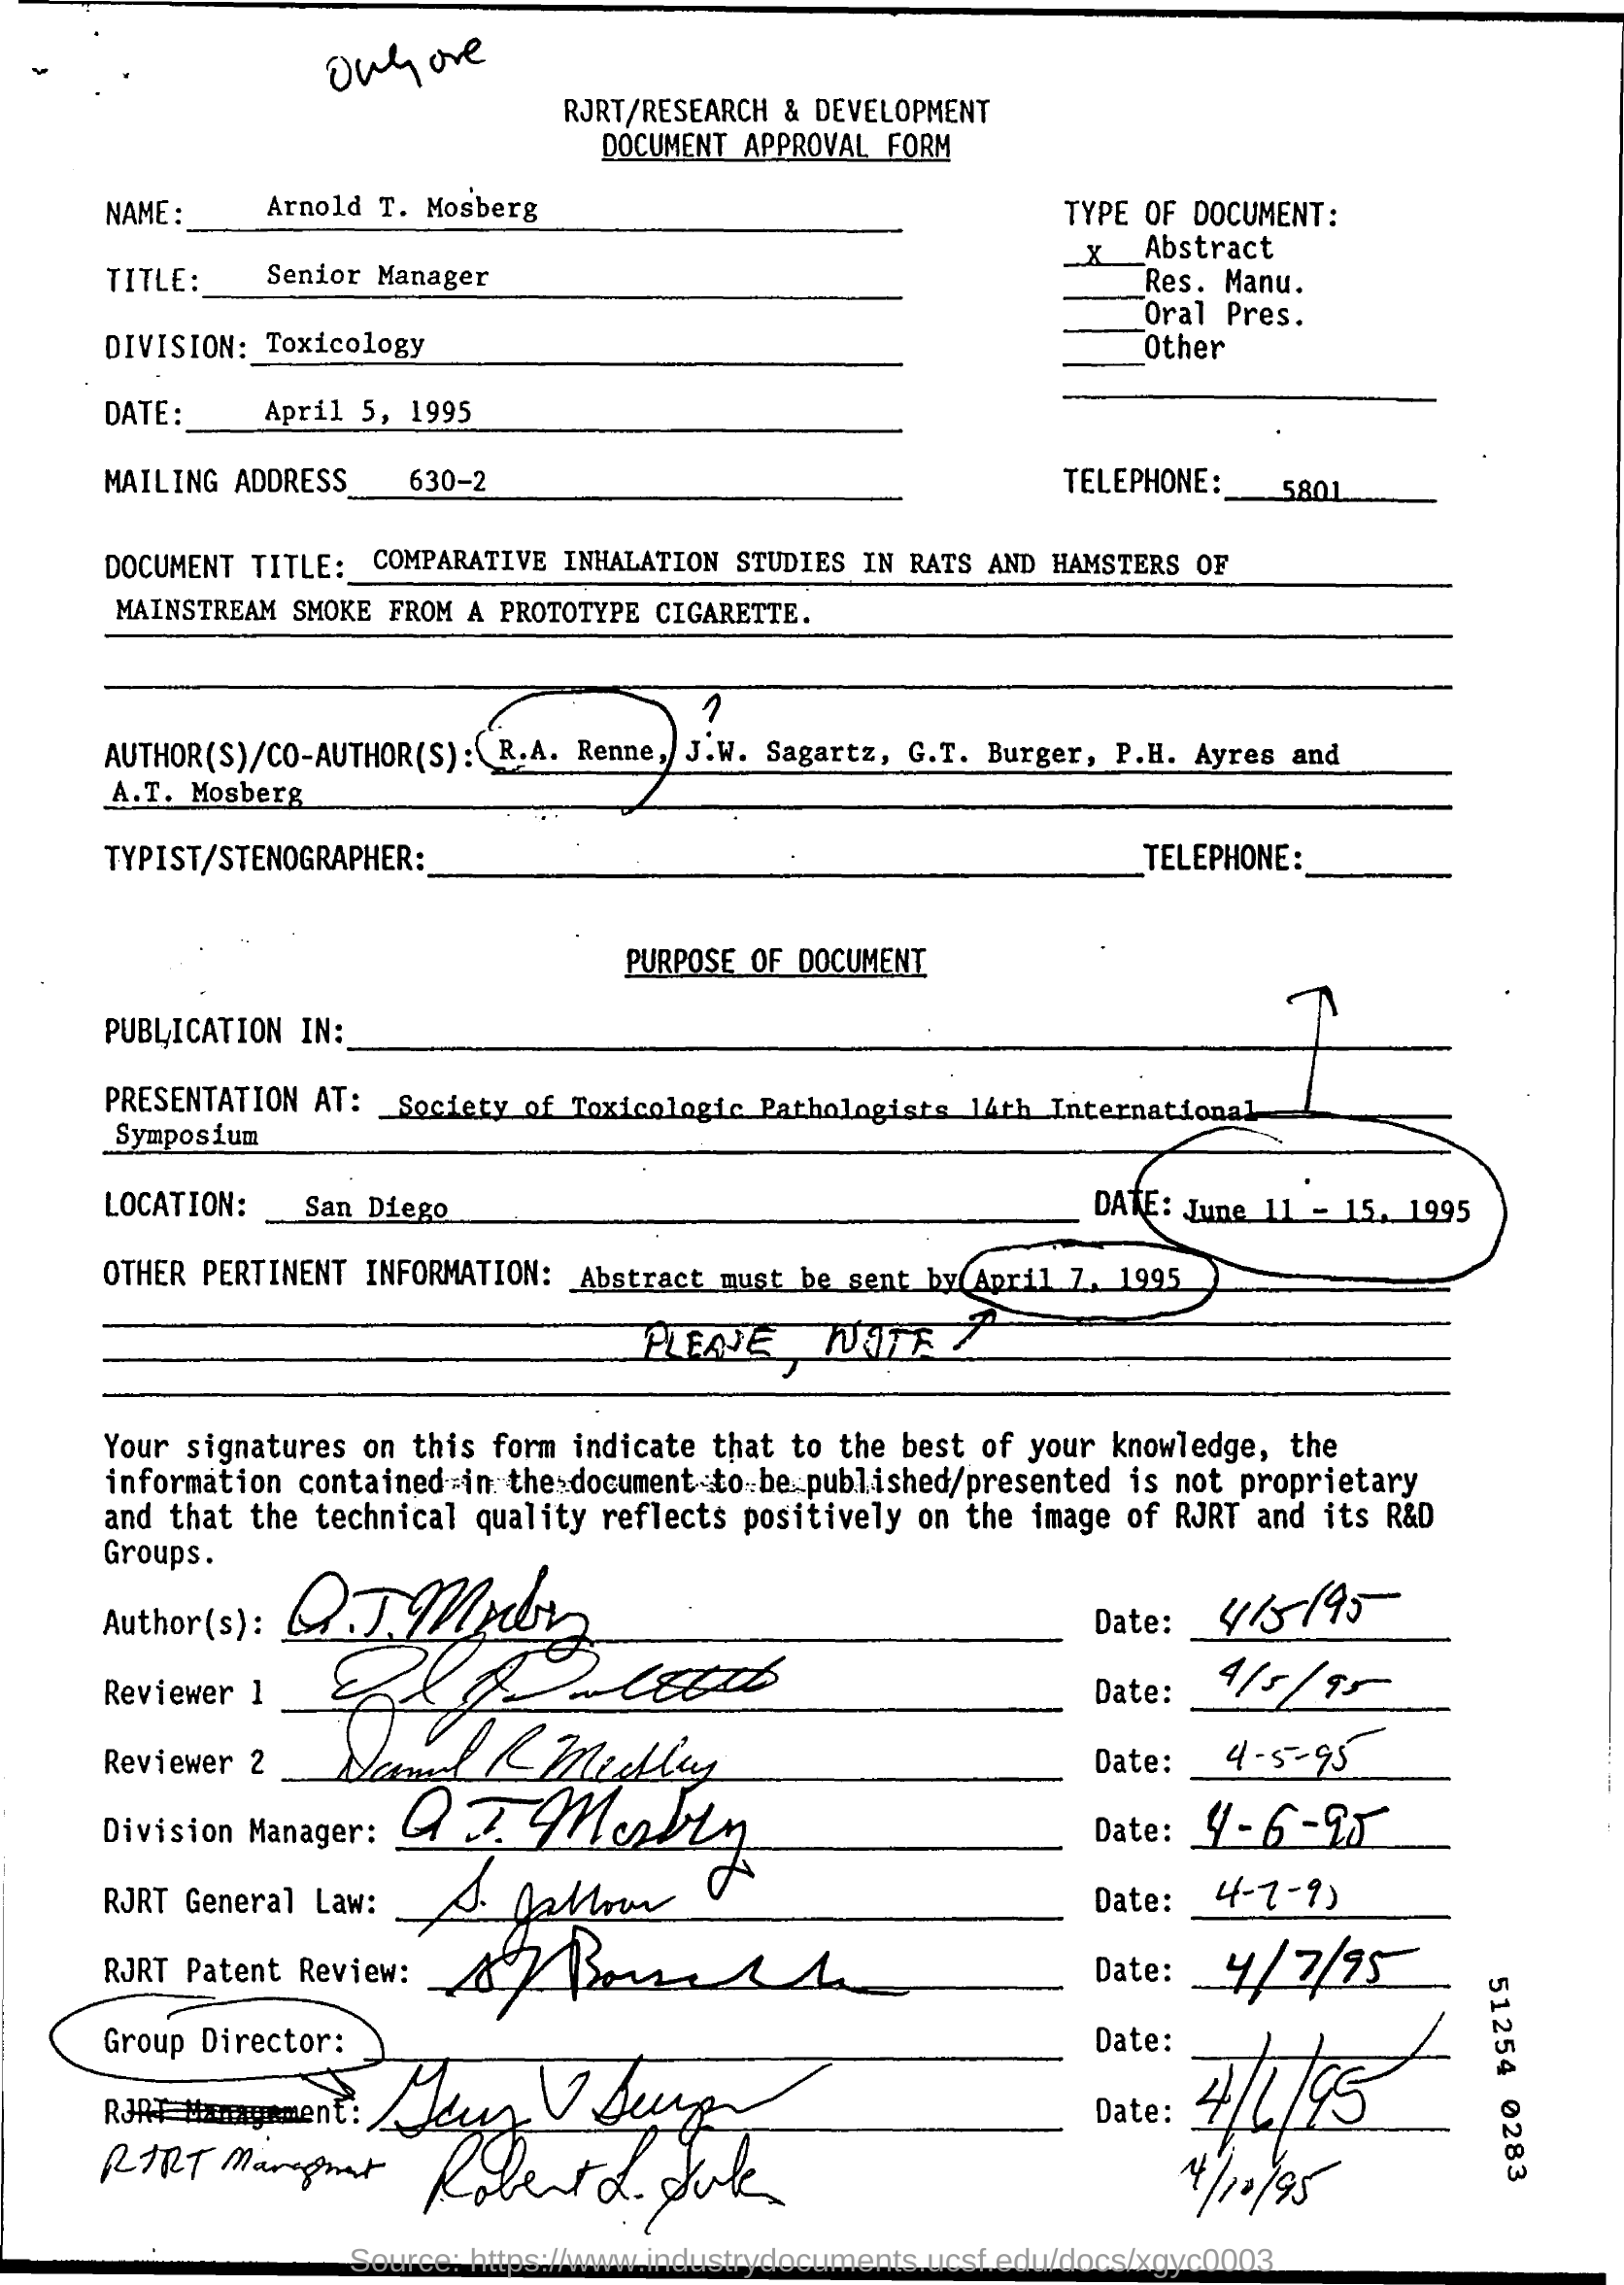

In [ ]:
example['image']